![NASA](http://www.nasa.gov/sites/all/themes/custom/nasatwo/images/nasa-logo.svg)

<center>
<h1><font size="+3">Python Course for Advanced Users</font></h1>
<h2>GSFC - NCCS Series</h2>
</center>

---

<center>
    <h2><font color="red">Machine Learning on ADAPT JupyterHub</font></h2>
</center>

## What We Will Cover

- Accessing the JupyterHub server
- Setting up your Python environment to access machine-learning packages
- Short example using Tensorflow on the MNIST data set


## <font color="red">Accessing ADAPT GPU Nodes with JupyterHub</font>

In order to access GPU systems with JupyterHub, you must first have:
- NCCS username
- RSA key fob/app
- An account on ADAPT's GPU nodes (ml101/ml102), or ICESat-2 Nodes

If you don't have this set up, please see: https://www.nccs.nasa.gov/user_info/new_user

Next you must create a NAMS request for "NCCS Web Services" on this page: https://idmax.nasa.gov/nams/user/ 

After submission, send a ticket to NCCS Support (support@nccs.nasa.gov) to ensure they properly set up access to JupyterHub. 

After your account is configured properly, use your Firefox or Chrome browser to visit:
- GPU Nodes (https://jh-ml.nccs.nasa.gov/)
- ICESat-2 Nodes (https://jh-icesat.nccs.nasa.gov/)

You will be validated by Launchpad and may have to to log in with your NCCS LDAP username and password. Then you'll be redirected to the JupyterHub Server Options page:
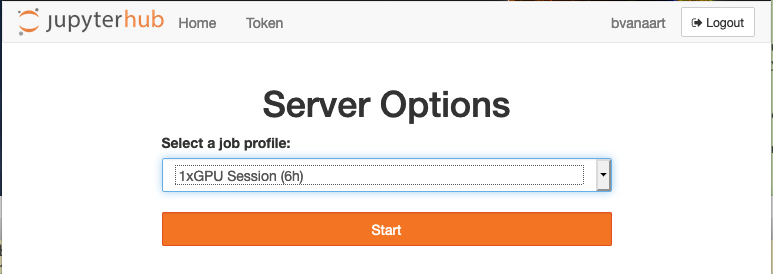



This dropdown menu will allow you to select 1x, 2x, or 4xGPUs, or just a CPU Session. For this tutorial, 1xGPU will work best. Click Start to try to allocate your session.

The system will take several seconds to attempt to allocate the session. If a GPU is available, you will soon see the JupyterHub Launcher interface:
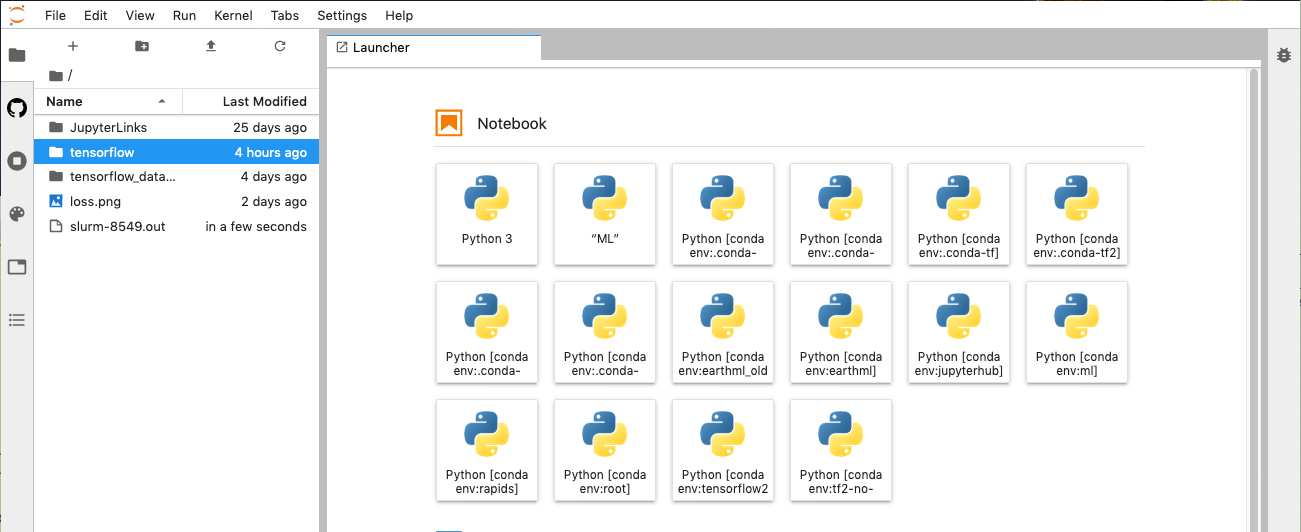

## <font color="red">Setting up your Python Environment on ADAPT</font>

ADAPT has several built-in conda virtual environments, which you can select from the set of Python icons. Most of them are described <A HREF="view-source:https://www.nccs.nasa.gov/nccs-users/instructional/adapt-instructional/adapt-gpu">on this page</A>. However, we will need to create a custom Python environment with up-to-date packages to run our Tensorflow example:
- TensorFlow 2.2+
- tensorflow_datasets (for MNIST hand-written digits test dataset)

### Creating a Virtual Environment
We will use **conda** to create a personalized virtual environment with Python, allowing you to add packages to a basic Anaconda distribution.  <b>Conda</b> is a full-featured package and environment manager that can handle library dependencies, and works with other software stacks--not just Python.


To create this new virtual environment, we need a basic command-line, so scroll to the bottom of  the page a click on the Terminal button:
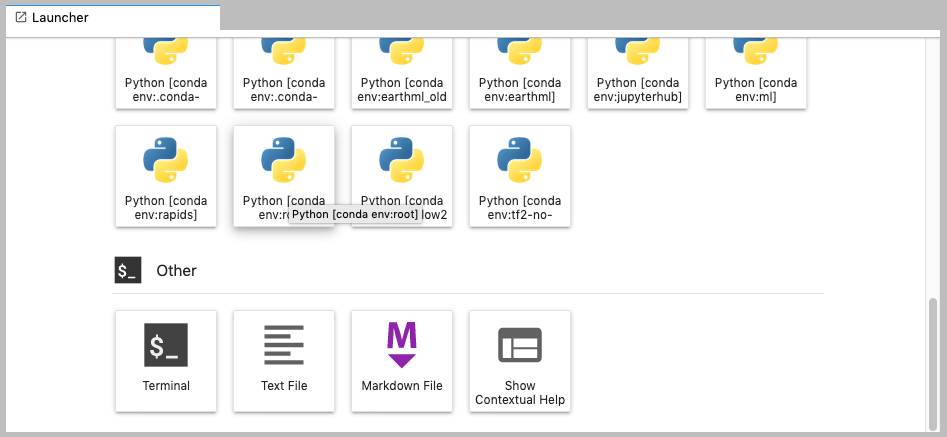

By default, conda will create the new environment under `$HOME/.conda/envs`

But this may use too much disk space (~5GB) for your `$HOME` partition, so you need to create (or move) your .conda folder under `$NOBACKUP` and link back to the `$HOME` location: <br>
`mkdir $NOBACKUP/.conda` <br>
`ln -s $NOBACKUP/.conda $HOME/.conda`

To put it somewhere else, set up an environment variable such as:
- For bash: `% export CONDA_ENVS_PATH=/att/nobackup/$USER/<custom_path>/envs`
- For csh: `% setenv CONDA_ENVS_PATH /att/nobackup/$USER/<custom_path>/envs`

Then create your virtual environment with:

`conda create --name tf2 pip anaconda`    _(Named for TensorFlow 2.X)_

*Please note: this command downloads the latest stable anaconda python to create your new personal environment, and will take several minutes to verify the environment!*

When the new environment is ready, activate it with:

`conda activate tf2`

And the next time you want to use this environment, reactivate it with the same activate command used above. 


### Install TensorFlow packages
After activation, you will notice the command prompt is now preceeded by the venv name (tf2 or whatever you named it). While this venv is active, you can use "pip" to install additional packages into it. For the most recent stable version of TensorFlow (2.X) use:

`pip install tensorflow==2.2`

Or for the version supporting Intel CPU performance enhancements, such as AVX2, use the nightly development version:

`pip install tf-nightly`

Also install the `tensorflow-datasets` package, which is needed to retrieve the MNIST example data:<br><br>
`pip install tensorflow-datasets`<br>

Then ensure we have a version of CUDA that is compatible with Tensorflow 2.2:  

`conda install -c anaconda cudatoolkit=10.1 cudnn=7.6`

Specifying the cudatoolkit version is critical, since the default version will not allow Tensorflow to utilize ADAPT GPUs.  Verify that the GPU is now accessible with the following command:

`python -c "import tensorflow as tf; tf.config.list_physical_devices()"`

The response should show:

`Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s`

Now, to make our new environment appear as a Python selection in JupyterHub, install this:

`conda install ipykernel`

## <font color="red">Python Code Example Using Tensorflow on MNIST Data</font>

The MNIST dataset is commonly used in ML demonstrations. It comprises 60,000 training examples and 10,000 test examples of the handwritten digits 0–9, formatted as 28x28-pixel monochrome images. This is a sample of the data set images:
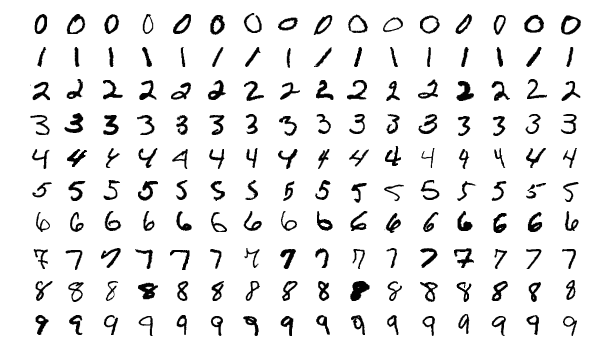
To download the data from `tensorflow_datasets`, first import the necessary packages.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

print(f"Tensorflow Version: {tf.__version__}")

### Import the MNIST data 
You can easily import the data into your Python code using `tfds.load`. This is the simplest way to build and load a `tf.data.Dataset`, which is the standard TensorFlow API to build input pipelines. Use these options:
- `with_info=True` : Will retreive metadata about the dataset and store it in the last variable ("info" below)
- `as_supervised=True` : puts the tuple (features, label) into the variable ("datasets" below)

In [ ]:
datasets, info = tfds.load(name="mnist", with_info=True, as_supervised=True)
mnist_train, mnist_test = datasets['train'], datasets['test']

print(info)

The tdfs.load command will download the 32MB MNIST dataset to your $HOME/tensorflow_datasets/mnist folder. Future tfds.load() calls will reuse this data. TensorFlow will provide several lines of output verifying the download, and initializing TensorFlow, such as: <br>
`Downloading and preparing dataset mnist/3.0.1 (download: 11.06 MiB, generated: 21.00 MiB, total: 32.06 MiB) to /home/bvanaart/tensorflow_datasets/mnist/3.0.1...`

Printing the returned "info" will list many attributes of the MNIST data set.

### Define a strategy to handle distribution across nodes
`tf.distribute.Strategy` is a TensorFlow API to distribute training across multiple CPUs or GPUs. It can be used with the integrated high-level **Keras** API, or your own custom training loops. The simplest implementation is the **MirroredStrategy()** shown below, which distrubutes the work among CPUs/GPUs on the same node.  If you want to use multiple nodes, you must use the MultiWorkerMirroredStrategy() and set up the TF_CONFIG environment variable.

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

This will provide INFO on the strategy, such as<br>
`INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)`

Next we print how many devices the strategy will replicate the data on.  It will automatically try use all GPUs that are visible to TensorFlow.<br>
`Number of devices: 1`

### Setup training pipeline

Create a scale function to normalize the image pixel values, since TFDS provides the images as tf.uint8, while the model expects tf.float32 in the range 0.0 - 1.0.

In [ ]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

Now use this function to scale the data, and apply the following transformations:
- map: normalize and parallelize the map transformation with num_parallel_calls
- cache: cache data before shuffling for better performance
- shuffle: For true randomness, set the shuffle buffer to the full dataset size
- batch: Batch after shuffling to get unique batches at each epoch.
- prefetch: Good practice to end the pipeline by prefetching for performance

In [ ]:
mnist_train = mnist_train.map(scale, num_parallel_calls=tf.data.experimental.AUTOTUNE)
mnist_train = mnist_train.cache()
mnist_train = mnist_train.shuffle(info.splits['train'].num_examples)
mnist_train = mnist_train.batch(128, drop_remainder=True)
mnist_train = mnist_train.prefetch(tf.data.experimental.AUTOTUNE)

### Build evaluation pipeline
Testing pipeline is similar to the training pipeline, with small differences:
- no `shuffle()` call
- caching is done after batching

In [ ]:
mnist_test = mnist_test.map(scale, num_parallel_calls=tf.data.experimental.AUTOTUNE)
mnist_test = mnist_test.batch(128)
mnist_test = mnist_test.cache()
mnist_test = mnist_test.prefetch(tf.data.experimental.AUTOTUNE)

### Create the model

Now use the Keras API to set up the TensorFlow layers within the context of `strategy.scope`.  This will automatically distribute the work among processors.

This example uses 5 TensorFlow layers. The input shape matches the shape of the MNIST character images. Since there are 10 possible characters, the final layer is set to 10 results.

In [ ]:
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
        metrics=['accuracy'],
    )


## Train the Model

In [ ]:
%%time

model.fit(
    mnist_train,
    epochs=20,
)

### Plot the deceasing loss over epochs
Use Pandas to plot a graph showing the decrease in loss (error) as training improves the model.


In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()
plt.savefig('loss.png')

### Validate the Model
Now we can use the model we just trained and apply it to the test data to verify that it works to properly identify hand-written digits. 

In [ ]:
test_loss, test_accuracy = model.evaluate(mnist_test)
print('\n\nTest Loss: {},    Test Accuracy: {}'.format(test_loss, test_accuracy))

### Save the Model

In [ ]:
model.save('my_MNIST_model')

Then to reload the model later, we can use this:

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('my_MNIST_model')